# Bidirectional Scan Phase Correction
Based on Yao's FixScanPhaseMismatchOfStack_SineWave.m

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from skimage.registration import phase_cross_correlation
import tifffile
%matplotlib inline

In [2]:
inpath = Path(r'D:\W2_DATA\kbarber\07_27_2025\mk355\green')
files = [x for x in inpath.glob("*.tif*")]

In [19]:
import mbo_utilities as mbo

data = mbo.imread(files[0])
data.fix_phase = False
data.roi = 1
data = data[:1500, 1, :, :]
frame = data.mean(axis=0)
frame.shape

Counting frames:   0%|          | 0/1 [00:00<?, ?it/s]

(550, 224)

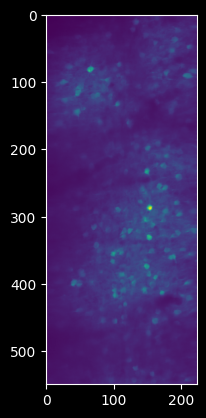

In [20]:
plt.imshow(frame)

In [21]:
def measure_shifts(frame, window_size=64, stride=24, upsample=10, min_percentile=55, max_shift=10):
    pre, post = frame[::2], frame[1::2]
    m = min(pre.shape[0], post.shape[0])
    a, b = pre[:m], post[:m]
    h, w = a.shape
    thresh = np.percentile(frame, min_percentile)
    x_pos, y_pos, shifts, intensities = [], [], [], []

    for y in range(0, h - window_size, stride):
        for x in range(0, w - window_size, stride):
            win_a = a[y:y+window_size, x:x+window_size]
            win_b = b[y:y+window_size, x:x+window_size]
            mean_int = (win_a.mean() + win_b.mean()) / 2
            if mean_int < thresh:
                continue
            try:
                shift_2d, _, _ = phase_cross_correlation(win_a, win_b,
                                                         upsample_factor=upsample, normalization=None)
                h_shift = float(shift_2d[1])
                if abs(h_shift) <= max_shift:
                    x_pos.append(x + window_size // 2)
                    y_pos.append(2 * (y + window_size // 2))  # Convert to frame coords
                    shifts.append(h_shift)
                    intensities.append(mean_int)
            except:
                continue

    return np.array(x_pos), np.array(y_pos), np.array(shifts), np.array(intensities)

x_pos, y_pos, shifts, intensities = measure_shifts(frame)
print(f'Measurements: {len(shifts)}, range: [{shifts.min():.2f}, {shifts.max():.2f}] px')

Measurements: 44, range: [0.10, 0.60] px


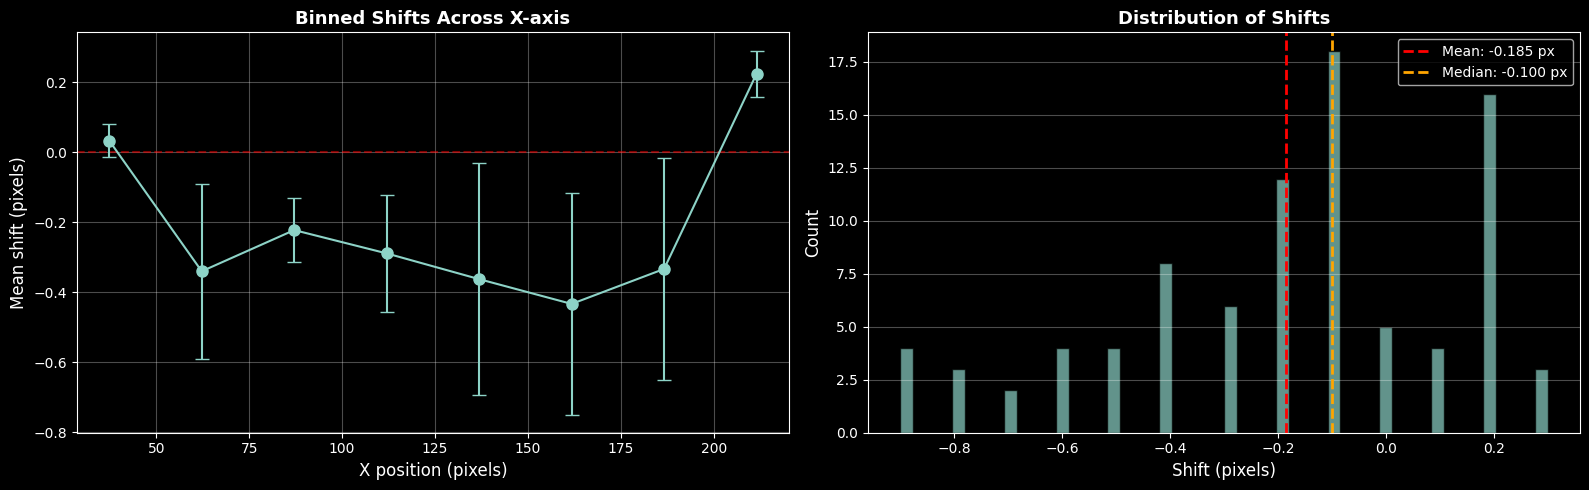


Shift statistics:
  Mean: -0.185 pixels
  Std:  0.317 pixels
  Min:  -0.900 pixels
  Max:  0.300 pixels
  Range: 1.200 pixels


In [24]:
# Create detailed visualization showing spatial distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Binned shifts across X-axis
w = frame.shape[1]
x_bins = np.linspace(0, w, 10)
x_bin_centers = (x_bins[:-1] + x_bins[1:]) / 2
x_binned_shifts = []
x_binned_stds = []

for i in range(len(x_bins) - 1):
    mask = (x_clean >= x_bins[i]) & (x_clean < x_bins[i+1])
    if mask.sum() > 0:
        x_binned_shifts.append(shifts_clean[mask].mean())
        x_binned_stds.append(shifts_clean[mask].std())
    else:
        x_binned_shifts.append(np.nan)
        x_binned_stds.append(np.nan)

x_binned_shifts = np.array(x_binned_shifts)
x_binned_stds = np.array(x_binned_stds)
valid_mask = ~np.isnan(x_binned_shifts)

ax1.errorbar(x_bin_centers[valid_mask], x_binned_shifts[valid_mask],
            yerr=x_binned_stds[valid_mask], fmt='o-', capsize=5, markersize=8)
ax1.axhline(0, color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('X position (pixels)', fontsize=12)
ax1.set_ylabel('Mean shift (pixels)', fontsize=12)
ax1.set_title('Binned Shifts Across X-axis', fontsize=13, weight='bold')
ax1.grid(True, alpha=0.3)

# Right plot: Distribution of shifts
ax2.hist(shifts_clean, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(shifts_clean.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {shifts_clean.mean():.3f} px')
ax2.axvline(np.median(shifts_clean), color='orange', linestyle='--', linewidth=2,
           label=f'Median: {np.median(shifts_clean):.3f} px')
ax2.set_xlabel('Shift (pixels)', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Distribution of Shifts', fontsize=13, weight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics
print(f'\nShift statistics:')
print(f'  Mean: {shifts_clean.mean():.3f} pixels')
print(f'  Std:  {shifts_clean.std():.3f} pixels')
print(f'  Min:  {shifts_clean.min():.3f} pixels')
print(f'  Max:  {shifts_clean.max():.3f} pixels')
print(f'  Range: {shifts_clean.max() - shifts_clean.min():.3f} pixels')

In [25]:
# Remove outliers using MAD (Median Absolute Deviation)
median_shift = np.median(shifts)
mad = np.median(np.abs(shifts - median_shift))
outlier_mask = np.abs(shifts - median_shift) > 3 * mad

x_clean = x_pos[~outlier_mask]
y_clean = y_pos[~outlier_mask]
shifts_clean = shifts[~outlier_mask]

print(f"Removed {outlier_mask.sum()} outliers")
print(f"Clean measurements: {len(shifts_clean)}, range: [{shifts_clean.min():.2f}, {shifts_clean.max():.2f}] px")

Removed 0 outliers
Clean measurements: 44, range: [0.10, 0.60] px


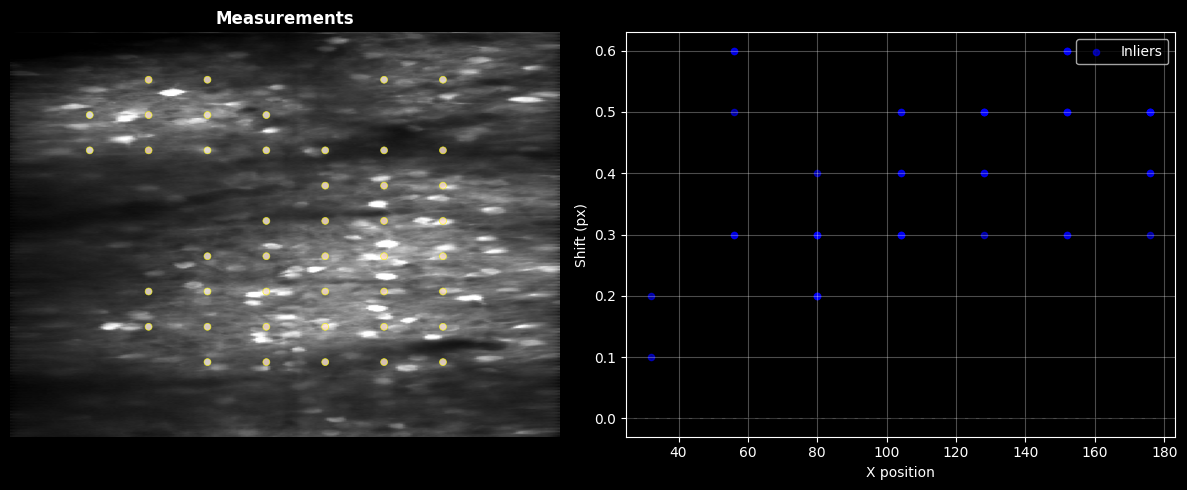

In [26]:
# Visualize measurements and outliers
# Make sure mask matches current data
outlier_mask = []
if len(outlier_mask) != len(x_pos):
    print(f'WARNING: Mask mismatch, recalculating outliers')
    median_shift = np.median(shifts)
    mad = np.median(np.abs(shifts - median_shift))
    outlier_mask = np.abs(shifts - median_shift) > 3 * mad

n_plots = 3 if outlier_mask.sum() > 0 else 2
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))
if n_plots == 2:
    axes = [axes[0], axes[1]]
vmin, vmax = np.percentile(frame, [1, 99.5])

# Full image
axes[0].imshow(frame, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto')
axes[0].scatter(x_clean, y_clean, c=shifts_clean, s=25, cmap='RdBu_r', vmin=-3, vmax=3,
               edgecolors='yellow', linewidth=0.5, alpha=0.8)
if outlier_mask.sum() > 0:
    for x_out, y_out in zip(x_pos[outlier_mask], y_pos[outlier_mask]):
        axes[0].add_patch(Rectangle((x_out-32, y_out-32), 64, 64,
                                    edgecolor='red', facecolor='none', linewidth=2))
axes[0].set_title('Measurements', fontsize=12, weight='bold')
axes[0].axis('off')

# Scatter
axes[1].scatter(x_clean, shifts_clean, c='blue', s=20, alpha=0.6, label='Inliers')
if outlier_mask.sum() > 0:
    axes[1].scatter(x_pos[outlier_mask], shifts[outlier_mask], c='red', s=40,
                   marker='x', linewidths=2, label='Outliers')
axes[1].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[1].set_xlabel('X position')
axes[1].set_ylabel('Shift (px)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Zoom
if outlier_mask.sum() > 0:
    x_out, y_out = x_pos[outlier_mask][0], y_pos[outlier_mask][0]
    zoom_size = 100
    x_start = max(0, int(x_out - zoom_size//2))
    y_start = max(0, int(y_out - zoom_size//2))
    zoom = frame[y_start:y_start+zoom_size, x_start:x_start+zoom_size]
    axes[2].imshow(zoom, cmap='gray', vmin=vmin, vmax=vmax)
    rect_x = x_out - x_start - 32
    rect_y = y_out - y_start - 32
    axes[2].add_patch(Rectangle((rect_x, rect_y), 64, 64,
                                edgecolor='red', facecolor='none', linewidth=2))
    axes[2].set_title(f'Outlier: shift={shifts[outlier_mask][0]:.2f}px', fontsize=10)
    axes[2].axis('off')

plt.tight_layout()

In [9]:
# Fit multiple models to the shift data
x_full = np.arange(frame.shape[1])  # All columns

# Polynomial models
poly2 = np.polyfit(x_clean, shifts_clean, 2)
poly3 = np.polyfit(x_clean, shifts_clean, 3)
dx_poly2 = np.polyval(poly2, x_full)
dx_poly3 = np.polyval(poly3, x_full)

# Sine model
def sine_model(x, A, LeftCorr, RightCorr):
    """Sine wave model: shift = A * sin(pi * x / width) + LeftCorr + (RightCorr - LeftCorr) * x / width"""
    return A * np.sin(np.pi * x / x.max()) + LeftCorr + (RightCorr - LeftCorr) * x / x.max()

sine_ok = False
try:
    # Initial guess: amplitude=0.5, left/right corrections from edges
    p0 = [0.5, shifts_clean[x_clean < 50].mean(), shifts_clean[x_clean > frame.shape[1] - 50].mean()]
    popt, _ = curve_fit(sine_model, x_clean, shifts_clean, p0=p0, maxfev=5000)
    A, LeftCorr, RightCorr = popt
    dx_sine = sine_model(x_full, A, LeftCorr, RightCorr)
    sine_ok = True
    print(f"Sine fit: A={A:.3f}, LeftCorr={LeftCorr:.3f}, RightCorr={RightCorr:.3f}")
except Exception as e:
    print(f"Sine fit failed: {e}")
    dx_sine = np.zeros_like(x_full)
    A, LeftCorr, RightCorr = 0, 0, 0

# Calculate residuals for each model
interp_poly2 = np.polyval(poly2, x_clean)
interp_poly3 = np.polyval(poly3, x_clean)
res_poly2 = np.sum((shifts_clean - interp_poly2)**2)
res_poly3 = np.sum((shifts_clean - interp_poly3)**2)

print(f"Poly2 residual: {res_poly2:.4f}")
print(f"Poly3 residual: {res_poly3:.4f}")

if sine_ok:
    interp_sine = sine_model(x_clean, A, LeftCorr, RightCorr)
    res_sine = np.sum((shifts_clean - interp_sine)**2)
    print(f"Sine residual: {res_sine:.4f}")

    # Select best model
    if res_sine < min(res_poly2, res_poly3):
        model = 'sine'
        dx_col = dx_sine
    elif res_poly3 < res_poly2:
        model = 'poly3'
        dx_col = dx_poly3
    else:
        model = 'poly2'
        dx_col = dx_poly2
else:
    if res_poly3 < res_poly2:
        model = 'poly3'
        dx_col = dx_poly3
    else:
        model = 'poly2'
        dx_col = dx_poly2

print(f"\nSelected model: {model}")
print(f"Correction range: [{dx_col.min():.3f}, {dx_col.max():.3f}] px")

Sine fit: A=0.500, LeftCorr=0.033, RightCorr=nan
Poly2 residual: 8.6348
Poly3 residual: 7.7526
Sine residual: nan

Selected model: poly3
Correction range: [-2.641, 0.290] px


Outliers mess this up

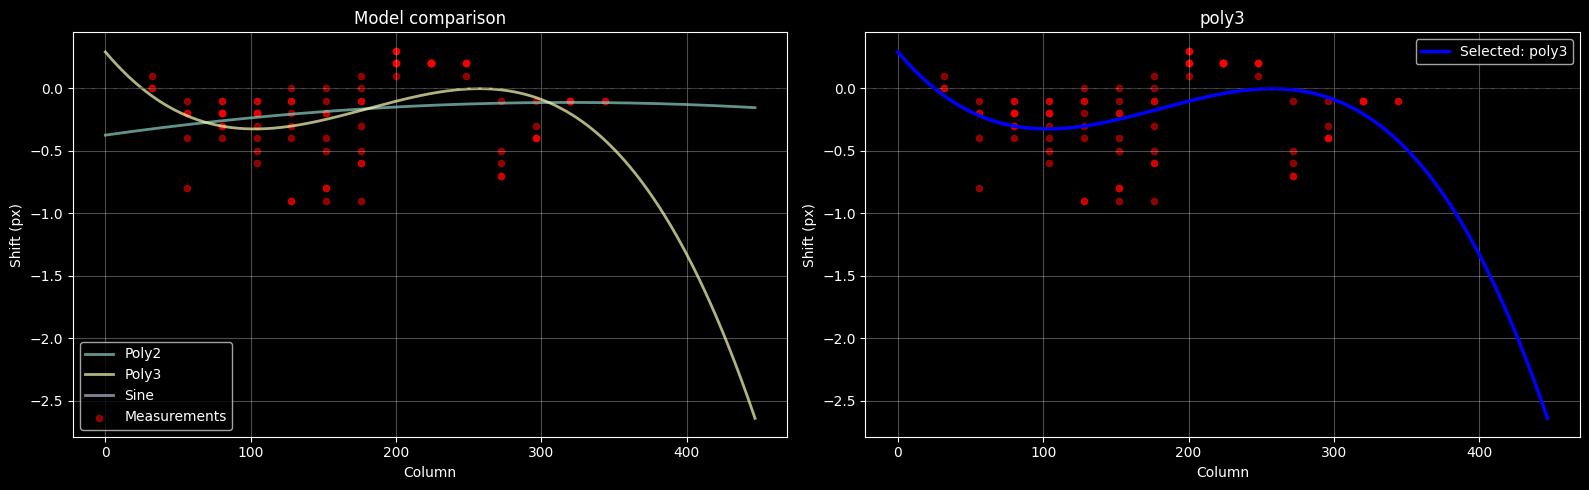

In [10]:
# Plot all models
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(dx_poly2, linewidth=2, label='Poly2', alpha=0.7)
axes[0].plot(dx_poly3, linewidth=2, label='Poly3', alpha=0.7)
if sine_ok:
    axes[0].plot(dx_sine, linewidth=2, label='Sine', alpha=0.7)
axes[0].scatter(x_clean, shifts_clean, c='red', s=20, alpha=0.5, label='Measurements')
axes[0].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[0].set_xlabel('Column')
axes[0].set_ylabel('Shift (px)')
axes[0].set_title('Model comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(dx_col, linewidth=2.5, label=f'Selected: {model}', color='blue')
axes[1].scatter(x_clean, shifts_clean, c='red', s=20, alpha=0.5)
axes[1].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Shift (px)')
axes[1].set_title(f'{model}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

In [22]:
# Optional: zero center
use_zero_center = True  # Turn off for now - let polynomial handle it
if use_zero_center:
    dx_col[130:385] = 0
    print(f'Zeroed center, range: [{dx_col.min():.2f}, {dx_col.max():.2f}] px')
else:
    print(f'Using full correction, range: [{dx_col.min():.2f}, {dx_col.max():.2f}] px')

NameError: name 'dx_col' is not defined

In [21]:
def apply_bidir_correction(I, dx_col):
    nr, nc = I.shape
    currentSlice = I.copy()
    currentSlice[1::2, :] = np.fliplr(currentSlice[1::2, :])
    even = currentSlice[1::2, :]
    m, even_corr = even.shape[0], np.zeros_like(even)
    x, x_src = np.arange(nc), np.arange(nc) - dx_col

    for r in range(m):
        F = interp1d(x, even[r, :], kind='linear', bounds_error=False, fill_value='extrapolate')
        even_corr[r, :] = F(x_src)

    Icorr = currentSlice.copy()
    Icorr[1::2, :] = even_corr
    currentSlice[1::2, :] = np.fliplr(currentSlice[1::2, :])
    Icorr[1::2, :] = np.fliplr(Icorr[1::2, :])
    return Icorr

corrected = apply_bidir_correction(frame, dx_col)
print('Corrected')

NameError: name 'dx_col' is not defined

In [ ]:
# Process full stack
if data.ndim > 2:
    print(f'Processing stack: {data.shape}')
    corrected_stack = np.zeros_like(data, dtype=np.float32)

    if data.ndim == 4:  # (Z, T, Y, X)
        for z in range(data.shape[0]):
            for t in range(data.shape[1]):
                corrected_stack[z, t, :, :] = apply_bidir_correction(data[z, t, :, :].astype(float), dx_col)
            print(f'  Completed Z={z+1}/{data.shape[0]}')
    elif data.ndim == 3:  # (T, Y, X) or (Z, Y, X)
        for i in range(data.shape[0]):
            corrected_stack[i, :, :] = apply_bidir_correction(data[i, :, :].astype(float), dx_col)
            if (i + 1) % 10 == 0:
                print(f'  Completed {i+1}/{data.shape[0]}')

    output_stack = inpath / f'{files[0].stem}_corrected.tif'
    tifffile.imwrite(output_stack, corrected_stack.astype(np.int16), compression='zlib')
    print(f'Saved: {output_stack.name}')
else:
    # Single frame
    output_path = inpath / f'{files[0].stem}_corrected.tif'
    tifffile.imwrite(output_path, corrected.astype(np.int16))
    print(f'Saved: {output_path.name}')

In [ ]:
# Save
tifffile.imwrite(inpath / 'corrected_sine_method.tif', corrected.astype(np.int16))
np.save(inpath / 'shift_pattern.npy', dx_col)
np.save(inpath / 'sine_params.npy', np.array([A, LeftCorr, RightCorr]))
print('Saved')

In [ ]:
# Process full stack
print(f'Processing stack: {data.shape}')
corrected_stack = np.zeros_like(data, dtype=np.float32)

for z in range(data.shape[0]):
    for t in range(data.shape[1]):
        corrected_stack[z, t, :, :] = apply_bidir_correction(data[z, t, :, :].astype(float), dx_col)
    print(f'  Z={z}')

output_stack = inpath / f'{original_tif.stem}_corrected.tif'
tifffile.imwrite(output_stack, corrected_stack.astype(np.int16))
print(f'Saved: {output_stack.name}')